# Data Processing

This jupiter notebook is the main notebook for the project. <br>

The goals are to import all the wave data, preprocess them (filter and segment if needed), extract features and then train pattern recognition models on those.

In [1]:
#imports
import scipy
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import iirnotch
import warnings
warnings.filterwarnings("ignore")


import statistics
import math
import os

### <u> <b> 1. Import data

In [2]:
# Import function:
def import_data(subject,motion,side, wave):
    
    #input: subject nbr, motion nbr, side(r or l)
    #returns: corresponding EMG and IMU files

    data_dir = "cut_data/s" + str(subject) + "/s" + str(subject) + "_m" + str(motion) + "_" + side + "_w" + str(wave) + ".csv" 
    
    data = pd.read_csv(data_dir)
    
    return data


#For visualisation:
def plot_sample(wave_frame):
    
    labels = ['time', 'ch1', 'ch2', 'ch3', 'ch4','x_acc', 'y_acc', 'z_acc', 'x_rot', 'y_rot', 'z_rot'] 
    
    t = wave_frame.time
    
    fig, axs = plt.subplots(10,figsize=(16,12))
    axs[0].plot(t,wave_frame.ch1)
    axs[1].plot(t,wave_frame.ch2)
    axs[2].plot(t,wave_frame.ch3)
    axs[3].plot(t,wave_frame.ch4)
    axs[4].plot(t,wave_frame.x_acc)
    axs[5].plot(t,wave_frame.y_acc)
    axs[6].plot(t,wave_frame.z_acc)
    axs[7].plot(t,wave_frame.x_rot)
    axs[8].plot(t,wave_frame.y_rot)
    axs[9].plot(t,wave_frame.z_rot)
    
    
    for k in range(0,10):
        axs[k].set_ylabel(labels[k+1])
        axs[k].grid()
    
    plt.show()

In [3]:
#data = pd.read_csv("cut_data/s1/s1_m2_r_w2.csv")

#Define constants:
fs = 512 #Hz  (sample frequency)

#Import the data at subject,motion,side:

subject_number = 1
motion_number = 8
side = 'r' #please use 'r' or 'l'
wave_number = 2



data = import_data(subject_number,motion_number,side, wave_number)

In [4]:
data

,Unnamed: 0,time,ch1,ch2,ch3,ch4,x_acc,y_acc,z_acc,x_rot,y_rot,z_rot
0,0,0.000000,-1.278716,-11.109688,-12.388404,-18.088970,4.251735,2.455105,10.879337,120.922380,-262.015267,-221.379916
1,1,0.001953,-1.287083,-11.093100,-12.380182,-18.107577,4.246905,2.451483,10.867261,175.232006,-262.015267,-296.775653
2,2,0.003906,-1.304392,-11.067929,-12.372321,-18.093441,4.242074,2.447860,10.855186,229.541633,-262.015267,-372.171391
3,3,0.005859,-1.314272,-11.082065,-12.396338,-18.068560,4.236301,2.450368,10.850656,241.431184,-262.015267,-388.677147
4,4,0.007812,-1.309801,-11.074276,-12.384077,-18.066901,4.229055,2.462444,10.857901,187.121557,-262.015267,-313.281409
...,...,...,...,...,...,...,...,...,...,...,...,...
1531,1531,2.990234,-1.289246,-11.031364,-12.320610,-18.014468,4.384978,2.562736,10.918286,163.612745,-262.015267,-280.645128
1532,1532,2.992188,-1.350477,-10.987009,-12.337486,-18.033220,4.376526,2.576019,10.879645,217.920863,-262.015267,-356.038771
1533,1533,2.994141,-1.308503,-10.954049,-12.262552,-17.901237,4.372550,2.586530,10.848252,253.053063,-262.015267,-404.811306
1534,1534,2.996094,-1.310594,-10.975974,-12.286569,-18.010357,4.389456,2.584115,10.850668,198.742682,-262.015267,-329.414521


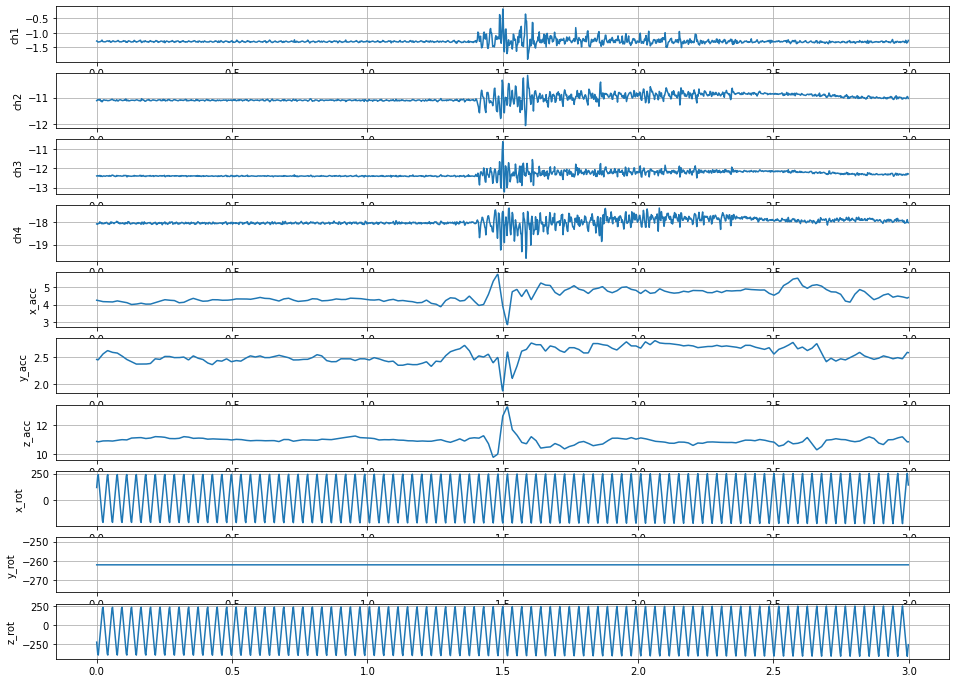

In [5]:
plot_sample(data)

### <u> <b> 2. Data pre-processing

In [6]:
def EMG_bp_filtering(signal,fs):
    
    #input: EMG signal and sample frequency
    #returns: bp-filtered EMG signal (cutoff defined here)
    
    low = 20 #Hz
    high = 250 #Hz
    cutoff = [low,high] #cutoff frequencies 

    num_bp, den_bp = butter(3, cutoff, 'bandpass',analog=False,fs=fs) #bandpass definition
    signal_filtered = filtfilt(num_bp, den_bp,signal) #application of the bandpass on the signal
    
    return signal_filtered


def EMG_notch_filtering(signal,fs):
    
    #input: EMG signal and sample frequency
    #returns: notch-filtered EMG signal (cutoff defined here)
    
    cutoff = 50 #Hz
    Quality = cutoff/3 #as defined by scipy for a -3dB notch
    
    num_notch, den_notch = scipy.signal.iirnotch(cutoff,Quality,fs)
    signal_filtered = filtfilt(num_notch, den_notch,signal) #application of the bandpass on the signal
    
    return signal_filtered


#Main EMG filtering function (bp and notch)
def EMG_filtering(signal,fs):

    #input: EMG signal (1 channel)
    #returns: filtered EMG-channel

    bp_filt_sig = EMG_bp_filtering(signal,fs)
    
    filt_sig = EMG_notch_filtering(bp_filt_sig,fs)
    
    return filt_sig


### <u> <b> 3. Feature extraction

In [7]:
def square_sig(sig):
    
    sqd_sig = []
    
    for t in sig:
        sqd_sig.append(t**2)

    return sqd_sig


In [8]:
def MAV(signal):
    
    abs_signal = [abs(val) for val in signal]
    
    mean = statistics.mean(abs_signal)
    
    return mean

In [9]:
def WL(signal): #(Chan et al., 2021)
    
    dif = []
    
    for t in range(0,len(signal)-2):
        
        dif.append(abs(signal[t+1]-signal[t]))
        
    waveform_length = sum(dif)
    
    return waveform_length
        

In [10]:
def RMS(signal): #(Phinyomark et al., 2014)
    
    sqrd_sig = square_sig(signal)
    
    rms = math.sqrt(sum(sqrd_sig)/len(sqrd_sig))
    
    return rms
    

In [ ]:
def ZCR(signal): #(Torres-Garcıa et al., 2022)
    
    rate = 0
    
    signe = np.sum(np.diff(np.sign(sample_signal)) != epsilon)
    

In [11]:
def get_features(signal):
    
    #input: signals
    #returns: list with the features for the one signal
    
    mav = MAV(signal)
    wl = WL(signal)
    rms = RMS(signal)
    
    features = [mav,wl,rms]
    
    return features


### <u> <b> 4. Apply the process

In [12]:
filepath_list = [] #define an empty list to store the filenames

subject_list = [] 
motion_list = []
side_list = []
wave_list = []


def get_file_of_subject(subject_nbr):
    
    #input: subject number as list
    #returns: fills up the predefined list for filepath, subjects, motions, sides and waves
    
    for sub_nbr in subject_nbr:
        directory = 'cut_data/s'+str(sub_nbr)
        
        for filename in os.listdir(directory): #go through all the data
            if filename != '.ipynb_checkpoints':
                #it happens often that jupiter notebook saves chekpoints which in turn break the code, 
                #so just to avoid that issue
                f = os.path.join(directory, filename)  
                filepath_list.append(f)
                subject_list.append(sub_nbr)

                #check the side
                if 'r' in f:
                    side_list.append('r')
                elif 'l' in f:
                    side_list.append('l')

                #check the motion
                for idx in range(1,9):

                    if 'm' + str(idx) in f:
                        motion_list.append(idx)

                #check the wave
                for idx in range(1,11):   
                    if ('w' + str(idx) in f) & ('w10' not in f):
                        wave_list.append(idx)

                    if (idx==10) & ('w' + str(idx) in f):
                        wave_list.append(idx)
                                  

In [13]:
def get_all_features(list_of_files,fs):
    
    #input: list of file paths
    #returns: one list for each defined feature
    
    labels = ['ch1', 'ch2', 'ch3', 'ch4','x_acc', 'y_acc', 'z_acc', 'x_rot', 'y_rot', 'z_rot'] 
    
    mav_list = []
    wl_list = []
    rms_list = []
    
    for file in list_of_files: #go over all files
                
        mavs_of_lab = []
        wls_of_lab = []
        rms_of_lab = []
            
        for lab in labels:
                   
            #import the datafile of the wave:
            wave = pd.read_csv(file)
            
            #first filter the signal:
            filt_sig = EMG_filtering(wave[lab],fs)
            
            #extract its features:
            mav_lab = MAV(filt_sig)
            wl_lab = WL(filt_sig)
            rms_lab = RMS(filt_sig)
            
            #and save the features in the list:
            mavs_of_lab.append(mav_lab)
            wls_of_lab.append(wl_lab)
            rms_of_lab.append(rms_lab)
            
        mav_list.append(mavs_of_lab)
        wl_list.append(wls_of_lab)
        rms_list.append(rms_of_lab)
            
    return mav_list,wl_list,rms_list


In [14]:
#get data from subjects:
subjects = [2]

get_file_of_subject(subjects)
#filepath_list.remove('cut_data/s3/.ipynb_checkpoints')
#subject_list.remove(subject_list[len(subject_list)-1])

In [15]:
mavs,wls,rmss = get_all_features(filepath_list,fs)

In [16]:
print(len(filepath_list))
print(len(motion_list))
print(len(side_list))
print(len(wave_list))
print(len(subject_list))
print(len(mavs))
print(len(wls))
print(len(rmss))

160
160
160
160
160
160
160
160


In [17]:
def create_full_frame(filepath_list,fs):
    
    #input: list with all the file paths
    #returns: dataframe with all labels and features , and list of the features
    
    #we get the features:
    mavs,wls,rmss = get_all_features(filepath_list,fs)
    
    
    #then we create the right labels for the columns:
    columns = ['subject','motion','side','wave']
    
    labels = ['ch1', 'ch2', 'ch3', 'ch4','x_acc', 'y_acc', 'z_acc', 'x_rot', 'y_rot', 'z_rot']
    
    features_labels=[]
    
    for lab in labels:
        features_labels.append(lab+'_MAV')
        features_labels.append(lab+'_WL')
        features_labels.append(lab+'_RMS')
        
    all_columns = columns + features_labels #all labels
    
    #create a list with full data:
    full_data=[subject_list,motion_list,side_list,wave_list]
    
    #then we create the right columns
    for k in range(0,len(labels)): #for each detailed label
        
        feat_mav = []
        feat_wl = []
        feat_rms = []
        
        for sig in range(0,len(mavs)): #get the values for each wave

            feat_mav.append(mavs[sig][k])
            feat_wl.append(wls[sig][k])
            feat_rms.append(rmss[sig][k])

        #and add to full data   
        full_data.append(feat_mav)
        full_data.append(feat_wl)
        full_data.append(feat_rms)
        
        
    #create a data dictionary:
    data_dictionary = {all_columns[0]:full_data[0]} #initiliase a dictionary with the labels

    for k in range(1,len(all_columns)):
        data_dictionary.update({all_columns[k]:full_data[k]}) #add all the values to the dictionary
    
    #make it into a dataframe:
    data_matrix = pd.DataFrame(data_dictionary) #and turn the dictionary into a dataframe
    
    
    return data_matrix,features_labels
        
    

In [ ]:
def get_all_features(list_of_files,fs):
    
    #input: list of file paths
    #returns: one list for each defined feature
    
    labels = ['ch1', 'ch2', 'ch3', 'ch4','x_acc', 'y_acc', 'z_acc', 'x_rot', 'y_rot', 'z_rot'] 
    
    mav_list = []
    wl_list = []
    rms_list = []
    
    for file in list_of_files: #go over all files
                
        mavs_of_lab = []
        wls_of_lab = []
        rms_of_lab = []
            
        for lab in labels:
                   
            #import the datafile of the wave:
            wave = pd.read_csv(file)
            
            #first filter the signal:
            filt_sig = EMG_filtering(wave[lab],fs)
            
            #extract its features:
            mav_lab = MAV(filt_sig)
            wl_lab = WL(filt_sig)
            rms_lab = RMS(filt_sig)
            
            #and save the features in the list:
            mavs_of_lab.append(mav_lab)
            wls_of_lab.append(wl_lab)
            rms_of_lab.append(rms_lab)
            
        mav_list.append(mavs_of_lab)
        wl_list.append(wls_of_lab)
        rms_list.append(rms_of_lab)
            
    return mav_list,wl_list,rms_list


In [18]:
data,features = create_full_frame(filepath_list,fs)

In [19]:
data

,subject,motion,side,wave,ch1_MAV,ch1_WL,ch1_RMS,ch2_MAV,ch2_WL,ch2_RMS,...,z_acc_RMS,x_rot_MAV,x_rot_WL,x_rot_RMS,y_rot_MAV,y_rot_WL,y_rot_RMS,z_rot_MAV,z_rot_WL,z_rot_RMS
0,2,1,l,2,0.009328,18.999445,0.016818,0.026737,48.697017,0.044247,...,0.028265,94.447493,61470.137787,109.831853,9.918287e-13,3.030259e-09,1.229914e-12,148.618495,96726.753128,172.826660
1,2,5,l,8,0.012442,24.020823,0.020168,0.029841,59.133265,0.050911,...,0.060256,94.653106,62157.477208,110.027314,9.918287e-13,3.030259e-09,1.229914e-12,148.942039,97808.320746,173.134228
2,2,4,l,8,0.021689,46.150169,0.042625,0.060637,114.584847,0.141024,...,0.027308,94.340849,60995.393553,109.713254,9.918287e-13,3.030259e-09,1.229914e-12,148.450685,95979.716112,172.640037
3,2,8,l,10,0.012797,24.286369,0.024529,0.033870,58.087463,0.060272,...,0.027539,94.306330,60900.124474,109.705719,9.918287e-13,3.030259e-09,1.229914e-12,148.396366,95829.804805,172.628179
4,2,6,r,7,0.025312,50.291674,0.047336,0.035456,70.474779,0.066784,...,0.044007,94.517035,61659.952236,109.889541,9.918287e-13,3.030259e-09,1.229914e-12,148.727923,97025.436945,172.917435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2,3,r,1,0.052861,111.800119,0.106129,0.054824,113.851617,0.095745,...,0.065859,94.059663,60031.004076,109.478056,2.401279e-04,1.391791e-01,7.514848e-04,148.008221,94462.194496,172.269938
156,2,2,r,1,0.054427,108.453047,0.115742,0.088674,156.954234,0.196579,...,0.060192,93.888955,59471.934493,109.407944,2.400126e-04,1.378632e-01,7.509557e-04,147.739604,93582.466754,172.159614
157,2,5,l,5,0.014023,27.922621,0.022794,0.028586,60.483306,0.048841,...,0.050258,94.094171,60221.344519,109.542097,9.918287e-13,3.030259e-09,1.229914e-12,148.062522,94761.705994,172.370711
158,2,4,l,5,0.019177,40.082086,0.038237,0.061420,116.933206,0.142230,...,0.027902,94.389640,61259.209278,109.776785,9.918287e-13,3.030259e-09,1.229914e-12,148.527460,96394.845140,172.740007


## <u> <b> 5. MACHINE LEARNING

In [20]:
#imports only used for the machine learning part:
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import RidgeClassifier
from matplotlib import axes as ax

### <b> Split and Standardise the data

In [21]:
#First split the data into randomized training set and test set (70-30% split):
data_train, data_test = train_test_split(data, test_size=0.3, train_size=0.7, random_state=4) #70% of training and 30% for testing

features = features  #features
labels = ["motion"] #name of the column storing the motion

#Standardize the data
data_training_scaled = StandardScaler().fit_transform(data_train[features]) #for the training data
data_training_labels = data_train[labels] #so the labels from the dataset for training

data_test_scaled = StandardScaler().fit_transform(data_test[features]) #for the test data
data_test_labels = data_test[labels] #so the labels from the dataset for testing

<b> k-NN <br>
    
Several values of k should be tested in order to decide the most fitting value for k for the kNN method. So it was decided to try values of $k = 1,2,..,50$

Accuracies of the kNN-method for each value of k: [0.625, 0.5208333333333334, 0.4791666666666667, 0.4166666666666667, 0.3333333333333333, 0.20833333333333334, 0.3541666666666667, 0.22916666666666666, 0.3333333333333333, 0.3333333333333333, 0.3125, 0.25, 0.2708333333333333, 0.3333333333333333, 0.3333333333333333, 0.3125, 0.3125, 0.25, 0.20833333333333334, 0.1875, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.25, 0.2708333333333333, 0.25, 0.2708333333333333, 0.25, 0.22916666666666666, 0.16666666666666666, 0.1875, 0.16666666666666666, 0.125, 0.125, 0.125, 0.10416666666666667, 0.14583333333333334, 0.10416666666666667, 0.14583333333333334, 0.125, 0.10416666666666667, 0.041666666666666664, 0.0, 0.0, 0.0, nan, nan, nan]
The optimal value for k is:  1


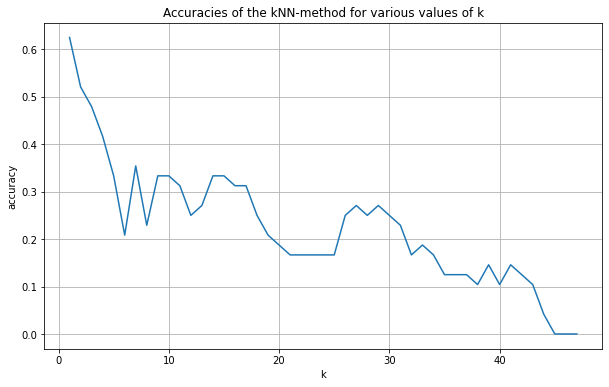

In [22]:
kNN_models = [0] * 50 #create a list with 50 entries in which the 50 models with k=1..50 will be saved
kNN_accuracies = [0] * 50 #create another list with 50 entries to save each accuracy

k_values=range(1,51)
for k in k_values:
    kNN_models[k-1] = KNeighborsClassifier(n_neighbors=k) #create the model with the k value
    kNN_models[k-1].fit(data_training_scaled,np.ravel(data_training_labels)) #training the defined kNN-Model
    kNN_accuracies[k-1] = np.mean(cross_val_score(kNN_models[k-1],data_test_scaled,np.ravel(data_test_labels),cv=LeaveOneOut())) #get the accuracy with leave-one-out cross validation

print("Accuracies of the kNN-method for each value of k:",kNN_accuracies) #print the list of accuracies to visu
optimal_k = kNN_accuracies.index(max(kNN_accuracies))  #determine the optimal value for k
print("The optimal value for k is: ",optimal_k + 1) #and print that optimal value (-1 because the index 0 corresponds to k=1)

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(k_values,kNN_accuracies)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Accuracies of the kNN-method for various values of k")
plt.show()

In [23]:
#Use the imported function KNeighborsClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
kNN_model = KNeighborsClassifier(n_neighbors=5) #with k=17 (best k-value found just before)
kNN_model.fit(data_training_scaled,np.ravel(data_training_labels)) #training the kNN-Model
#according to the warning received from python using the np.ravel() function allows to indicate that the row has to be used as an array


#then compute the confusion matrix:

#so first predict from the test features:
simulated_kNN_labels = kNN_model.predict(data_test_scaled)

#and then the confusion matrix can be obtained:
matrix_kNN = metrics.confusion_matrix(data_test_labels, simulated_kNN_labels) 


print("Confusion matrix of the kNN-method:")
print(matrix_kNN)

#from the obtained matrix, the matrix derived analyze can be determined:
accuracy_kNN = (matrix_kNN[0,0]+matrix_kNN[1,1])/(matrix_kNN.sum()) #(TP+TN)/(TP+TN+FP+FN)
precision_kNN = matrix_kNN[0,0]/(matrix_kNN[0,0]+matrix_kNN[1,0]) #TP/(TP+FP)
recall_kNN = (matrix_kNN[0,0])/(matrix_kNN[0,0]+matrix_kNN[0,1]) #TP/(TP+FN)
F1_kNN = (2*precision_kNN*recall_kNN)/(precision_kNN+recall_kNN) 


print("Accuracy of kNN algorithm: ",accuracy_kNN)
print("Precision of kNN algorithm: ",precision_kNN)
print("Recall rate of kNN algorithm: ",recall_kNN)
print("The F1 score of kNN algorithm: ",F1_kNN)

Confusion matrix of the kNN-method:
[[3 0 2 0 0 0 0 2]
 [0 5 0 0 0 0 0 0]
 [0 2 3 0 0 0 0 0]
 [0 4 0 3 0 0 0 0]
 [0 0 0 0 3 0 2 0]
 [0 1 0 0 0 5 0 0]
 [0 0 0 0 3 0 4 0]
 [0 0 0 0 0 0 0 6]]
Accuracy of kNN algorithm:  0.16666666666666666
Precision of kNN algorithm:  1.0
Recall rate of kNN algorithm:  1.0
The F1 score of kNN algorithm:  1.0


<AxesSubplot:>

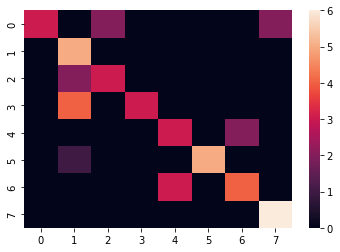

In [24]:
import seaborn


seaborn.heatmap(matrix_kNN)